# Extracting Data from a PDF Table: AI Ethics Policies
# Part 1: Exploring the PDF Format by Creating A Custom Table Extraction Tool

_Alistair Boyer_

Close your eyes and imagine a world where every dataset is nicely curated. 
There is a detailed data dictionary that explains the purpose of each column and all the values that could ever be contained within.
Each column has an optimal type associated with the data that provides convenient methods to access the various properties of the data. 
There are no duplicates across rows. There are no ambiguity across values. 
Now, __wake up__ because we all know that this is not the world we live in.
Working with data most often involves spending a disproportionate amount of time extracting and cleaning data from frustrating sources. 


A clear contender for the worst offender in the category of swallowing valuable time is tabular data stored in PDF files.
These portable files that are super convenient for presenting formatted information and dominate the document landscape.
In 2015, [Adobe's Phil Ydens revealed](https://youtu.be/5Axw6OGPYHw) that >70 million new PDFs were saved every day in the Google Cloud; and simple maths extrapolates the total number of PDFs to be well over 2 trillion. 
However, all this portability comes at a heavy cost. The data within a PDF file is stored as an almost random selection of texts and shapes and their properties and coordinates within each page. 
We have all experienced the actuality of this when dragging across text within a PDF page to find various words and phrases selected in a random order including page number and headers.
What makes extracting data from a PDF even more frustrating is the knowledge that this exact same data exists somewhere in a much more convenient form that someone has decided not to share. 

I have been reviewing AI Ethics policies and came across the 2019 [perspective article](https://doi.org/10.1038/s42256-019-0088-2) in _Nature Machine Intelligence_ by Anna Jobin, Marcello Ienca and Effy Vayena, titled "The Global Landscape of AI Ethics Guidelines" [__2019__, _Vol 1_, pp 389-399].
The article covers principles and guidelines for ethical artificial intelligence published across the globe and includes a list of these policies as Table S2 within the [PDF Supplementary Information](https://www.nature.com/articles/s42256-019-0088-2#Sec17). 


This two-part article describes my elongated journey into this challenge and covers the state-of-the-art for PDF extraction in May 2024.
[__Part 1__]("Extracting_Data_from_a_PDF_Table_Part_1.ipynb") starts with a custom approach to table extraction using __pypdf__ to match all text within the rectangles that make up the table and building an automated response to getting the data.
[__Part 2__]("Extracting_Data_from_a_PDF_Table_Part_2.ipynb") looks at the python packages that are designed for tabular data extraction,
starting with the __Adobe API__ for table extraction that reinforces their PDF experience with ML and AI techniques;
then looking at a selection of the most popular python packages: __pdfplumber__, __tabula__ and __camelot__.

In [2]:
# general imports
import numpy 
import pandas

In [3]:
import requests
import pathlib

# The SI data is available from the publisher; and is saved locally to GlobalLandscapeOfAIEthicsSI.pdf

PDF_URL = "https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-019-0088-2/MediaObjects/42256_2019_88_MOESM1_ESM.pdf"

PDF = pathlib.Path("data/GlobalLandscapeOfAIEthicsSI.pdf")

if not PDF.is_file():
    with PDF.open("wb") as f:
        f.write(requests.get(PDF_URL).content)

## PDF Data

A PDF file is a collection of text and graphics information and the information required to present this on a page, _i.e._ location, font, transformation, kerning, etc&hellip;.
A significant challenge is that unlike something like HTML where the structure of the file reflects the structure of the document, in PDF there is __no guarantee__ that order of data is correlated with its location on a page. 
There is an excellent description of PDF text operations in this [free book chapter by _Ryan Hodson_](https://www.syncfusion.com/succinctly-free-ebooks/pdf/text-operators)
and a handy visual cheat-sheet of PDF operators created [by the PDF Association](https://pdfa.org/wp-content/uploads/2023/08/PDF-Operators-CheatSheet.pdf).

 


## pypdf setup

`pip install pypdf`

pypdf is a family of packages commonly used to process PDF files using python. I first encountered these various PDF tools in 2020 and everything seemed confusing: there were various different forks at various stages of abandonment. [However, in 2024 things are much better!](https://pypdf.readthedocs.io/en/stable/meta/history.html) The original [pyPdf](https://pypi.org/project/pypdf/) [2005-2010] was created in 2005 as a tool for managing PDF documents offering features such as page reordering, page cropping and encryption. The last release of this package was in 2010 and by the end of 2011 a [PyPDF2](https://pypi.org/project/PyPDF2/) [2011-2016] fork was created with a focused on real-world application. Eventually, work on PyPDF2 also petered out and two other short lived forks emerged: [PyPDF3](https://pypi.org/project/PyPDF3/) [2018-2022] and [PyPDF4](https://pypi.org/project/PyPDF4/) [2018]. In 2022, development of PyPDF2 [2022] was renewed and quickly the team decided to merge back into pypdf (now all lowercase) to reduce the confusion. PyPDF3 and PyPDF4 are also welcomed to rejoin but are yet to do so. 


The key focus of pypdf has been on bulk document operations. It is a great tool for rotation, reorganisation, cropping, encryption, annotation, etc&hellip; but is __not__ focused on text extraction. 
However, it does provide tools to look at the elements within a PDF that provide insights to the mechanisms and challenges in data extraction.

pypdf reads PDF files through a `PDFReader` object that will open the path (or stream) of a file passed into it.
Each page of the resulting `PDFReader` object `pdf` is available by indexing its `.pages` attribute.
Accessing page 4 is achieved though `pdf.pages[3]`, remembering that pages are zero-indexed.
The text on page 4 is retrieved using the `.extract_text()` method but this returns a dump of all the text on the page. 
Looking at the first 500 characters of the result demonstrates difficulty into converting this into tabular data.

In [6]:
import pypdf

pdf = pypdf.PdfReader(PDF)

pdf.pages[3].extract_text()[:500]

' \n \n3 \n Table S 2. Ethics guidelines for AI by date of publishing (incl. details)  \n \nName of \nDocument/Website  Name of \nguidelines/principl\nes Issuer  Country \nof issu er Type of issu er Date of \npublishi\nng Target audience  Retri eval \nPrinciples of robotics  Principles for \ndesigners, builders \nand users of robots  Engineering and \nPhysical Sciences \nResearch Council UK \n(EPSRC)  UK Science \nfoundation  1-Apr-\n2011  multiple (public, \ndevelopers)  Linkhubs  \nEthique de la \nrecherche en robot'

## Finding Text and Rectangles

Table 2 is presented as tabular information with each cell surrounded by a rectangle. 
Information about graphics, including rectangles can also be extracted from each page of a PDF. 
So my strategy was to __find all text and its coordinates__, __find all rectangle's coordinates__ and map text into each rectangle that contains it.
Finally, __parsing the rectangles__ to rows and columns will deliver the tabular data. 
The `.extract_text()` method for PDF pages provides an interface to callbacks for custom parsing the elements on each page.
The [example](https://pypdf.readthedocs.io/en/stable/user/extract-text.html) in the pypdf API describes finding all text and rectangles as an example for creating SVGs from PDFs.

The first step was to extract all the rectangles and texts from the page and this process was enclosed in the `extracts_texts_rects_from_page()` function:
- First empty lists `rects` and `texts` are defined that will collect all the relevant information. An `fonts` empty double ended queue `collections.deque` is created to hold font information but this is set with `maxlen=1` because we are only interested in the last font.
- An enclosed function `visitor()` is the callback for objects encountered and takes the arguments: `op`, `args`, `cm`, `tm`. 
`op` is the object type with the object's arguments stored in `args`.
`cm` and `tm` are 2D transformation matrices.
  - The op code for a rectangle is `b"re"`. The rectangle arguments `args` is a tuple of `x`, `y`, `height`, `width` that is appended to the `rects` list.
  - The op code for font and size state information is `b"Tf"` and the font information stored in `args[0]` can be added to the `fonts` deque.

  - The op code for kerned text (the only text in our table) is `b"TJ"`. For these texts, `args` is a nested list of `bytes` containing the text split with integer kerning offset information. 
  The bytes part can be collected by checking for a `.decode` attribute and joined together with `b"".join`.
  If the text is empty, it can be skipped by returning. 
  The text value, position from `tm[4], tm[5]` and last font `fonts[-1]` can be appended to the text list.
  
-  With the parser function created, the `.extract_text()` method is called on the PDF page object and the callback function is registered against the  `visitor_operand_before=` argument. 
-  Finally, each lists is converted to a `pandas.DataFrame` with appropriate columns labels for convenience.

Passing page 4, the first page of Table S2, into the `extracts_texts_rects_from_page()` function with the correct encoding returns the associated `texts` and `rects`.

In [8]:
import collections


def extracts_texts_rects_from_page(page):
    
    # initialise lists to collect data
    rects = list()
    texts = list()
    fonts = collections.deque(maxlen=1)

    # callback for each element within the PDF
    def visitor(op, args, cm, tm):

        # rectangle op code
        if op == b"re":
            # collect rectangle args
            rects.append(args)
            return
        
        # font op code
        if op == b"Tf":
            # collect font
            fonts.append(args[0])
            return
        
        # text op code
        if op == b"TJ":

            # collect the texts parts, i.e. the parts with a .decode() attribute
            text = b"".join((b if hasattr(b, "decode") else b"") for b in args[0])

            # skip empty texts
            if not text:
                return
            
            # append the details
            texts.append((text, tm[4], tm[5], fonts[-1]))
            return

        
    # do the extraction
    page.extract_text(
        # visitor used for parsing
        visitor_operand_before=visitor,
    )

    # collect texts to a DataFrame
    texts = pandas.DataFrame(texts, columns=["text", "x", "y", "font"])
    
    # collect rects to DataFrame
    rects = pandas.DataFrame(rects, columns=["x", "y", "w", "h"])
    
    return texts, rects


texts, rects = extracts_texts_rects_from_page(pdf.pages[4])

Looking at `texts` shows the fragmentary nature of the text on the page. The first text is the page number at the bottom of the page followed by fragments of each table cell.
The table content is in a consistent order - something that is not guaranteed universally with PDFs.
The text is mostly legible in the `bytes` objects, indicating ASCII characters but any text that has the font `"/F5"` is a seemingly random collection of bytes.

In [10]:
texts.head(20)

,text,x,y,font
0,b' ',522.100,747.00,/F1
1,b' ',90.024,733.68,/F1
2,b'4',516.100,52.68,/F1
3,b' ',522.100,52.68,/F1
4,b' ',90.024,38.88,/F1
5,b'the wider ',422.980,713.62,/F1
6,b'Internet ',422.980,706.18,/F1
7,b'ecosystem)',422.980,698.62,/F1
8,b' ',452.260,698.62,/F1
9,b'Machine learning: the ',90.024,690.70,/F1


## Decoding Text

The encoding information within the document is saved in the font definitions that are references on each page: `pdf.pages[n]["/Resources"]["/Font"]`.
There are two types of encoding: standardised encoding and Identity-H.
Standardised encoding represents an encoding that is standardised, for example "/WinAnsiEncoding" is "windows-1252" encoding in python.
Identity-H is a custom mapping of the byte values to unicode values that is stored in a [CID map](https://adobe-type-tools.github.io/font-tech-notes/pdfs/5014.CIDFont_Spec.pdf).
I created a simplistic function `load_cid_map()` to extract this information but will skip over the details here.

The function `get_font_decoders()` creates decoders for each of the fonts:
- The function iterates over all the fonts on a page `page['/Resources']['/Font'].items()` and looks at their `"/Encoding"`.
- If the font has '/WinAnsiEncoding' encoding then python can decode the bytes using the the `.decode("windows-1252")` method.
- If the font has '/Identity-H' encoding then the python loads the custom unicode map and then creates an appropriate decoder.

Applying this function reveals that the text has been converted and that the mysterious `b'\x00\xb1'` with `'/Identity-H'` encoding within font `/F5` was an en-dash "–".

In [12]:
import re


def load_cid_map(cid):
    
    # default 0x0000 to an empty str
    mapping = {0: ''}

    # iterate over the lines
    line_iter = iter(cid.splitlines())
    for line in line_iter:
        
        # look for the relevant mapping range tag
        # beginbfchar  is mapping for a single char: <CHAR_FROM> <CHAR_TO>
        # beginbfrange  is mapping for an inclusive range of chars:  <CHAR_FROM_RANGE_START> <CHAR_FROM_RANGE_END> <CHAR_TO_OFFSET> 
        if line.endswith(b'beginbfchar') or line.endswith(b'beginbfrange'):
            
            # the mapping range tag starts with an int that indicates the number of rows
            for _ in range(int(line.split(b' ')[0])):
                
                # use general regex to match all <hex_value> 
                # this will be 2 for beginbfchar, or 3 for beginbfrange
                from_start, *from_stop, to_start = [int(x, 16) for x in re.findall(r'<([0-9A-F]+)>', next(line_iter).decode())]
                from_stop = from_stop[0] if from_stop else from_start
                
                # enumerate the whole mapping range N.B. the stop is an inclusive value
                for n, from_value in enumerate(range(from_start, from_stop + 1)):
                    
                    # save the mappinng
                    mapping[from_value] = chr(n + to_start)
    
    return mapping



def get_font_decoders(page):
    decoders = dict()

    # iterate over fonts
    for font_name, font in page['/Resources']['/Font'].items():
        
        # WinAnsiEncoding
        if font['/Encoding'] == '/WinAnsiEncoding':
            # use python to .decode 
            decoders[font_name] = lambda b: b.decode("windows-1252")
            continue

        # Unicode Mapping
        if font['/Encoding'] == "/Identity-H":
            # load the custom map
            cid_map = load_cid_map(font['/ToUnicode'].get_data())
            # use the map to decode
            decoders[font_name] = lambda b: "".join(map(cid_map.get, b))

    return decoders




for font, decoder in get_font_decoders(pdf.pages[4]).items():
    texts.loc[texts['font'] == font, 'text'] = texts.loc[texts['font'] == font, 'text'].apply(decoder)
    
texts.head(20)

,text,x,y,font
0,,522.100,747.00,/F1
1,,90.024,733.68,/F1
2,4,516.100,52.68,/F1
3,,522.100,52.68,/F1
4,,90.024,38.88,/F1
5,the wider,422.980,713.62,/F1
6,Internet,422.980,706.18,/F1
7,ecosystem),422.980,698.62,/F1
8,,452.260,698.62,/F1
9,Machine learning: the,90.024,690.70,/F1


## Gathering Text into the Rectangles

Gathering the text relies on processing in a meaningful order. 
In graphics, the __bottom left__ is the zero reference with `y` increasing up the page and `x` increasing across the page to the right.
So the data should be sorted y-descending and x-ascending.

In [14]:
texts.sort_values(["y", "x"], ascending=[False, True], inplace=True)
texts.reset_index(drop=True, inplace=True)

Looking at `rects` reveals some problems. 

- There are several rectangles that are actually lines (i.e. width < 1 or height < 1) that can be ignored.
The lines can be filtered out by their width and height being "< 1.0".

- Each of the rectangles that makes up the table borders is actually several rectangles overlapping and these should be combined to a single rectangle.
Removing the duplicated rectangles is more of a challenge because their float positions are not perfectly duplicated i.e. `668.73` _cf_ `668.74`.
A unique index for each rectangle can be constructed by rounding the value to the closest `int` and collecting them as a tuple. This can be used to `.groupby` the DataFrame and the grouped values can be aggregated by taking their mean value.

- Finally the rectangles can be sorted in the same order as `texts` and the index reset to maintain the new order.

In [16]:
# ignore lines 
rects = rects[rects["w"] > 1.0]
rects = rects[rects["h"] > 1.0]

# group closely oerlapping rects
rects = rects.groupby(
    # by converting each rect a list of its int coordinates
    rects.apply(lambda row: tuple(int(x) for x in row), axis=1)
    # and aggregating using "mean"
).agg("mean").reset_index(drop=True)

rects.sort_values(["y", "x"], ascending=[False, True], inplace=True)
rects.reset_index(drop=True, inplace=True)

The next step is to collect the `texts` into the `rects` that contain that text.
- A `"Text"` column can be initialised to be an empty `str` within `rects` to store this information.
- Each of the `text` and its `x`, `y` can be considered by iteration using the `.iterrows()` method. 
- The relevant entry in `rects` can be selected by comparing the `x`, `y` values with the coordinates of the rectangle; and the matching rectangles can have `text` appended to the `"Text"` column.

In [18]:
# Prepare a column to gather text inside each rect
rects['Text'] = ""

# iterate over the texts
for _, (text, x, y, font) in texts.iterrows():
    
    rects.loc[
        (rects['x'] < x)
        & ((rects['x'] + rects['w']) > x)
        & (rects['y'] < y)
        & ((rects['y'] + rects['h']) > y),
        "Text"
    ] += text

The final challenge is to turn the `rects`into rows and columns. 

- The column number can be calculated by ranking the rectangle's `x` position (rounded to an `int`).
The ranking should be performed with `method="dense"` so that rectangles with the same x-position get the same rank and the ranks are consecutive.

- The rows can be found using a similar strategy.
Grouping by the "y" column (again rounded to an `int`) delivers the data row by row and the `sort=` kwarg should be set to `False` so that the order is maintained: `rects.groupby(rects['y'].apply(int), sort=False)`.
The data within the row can be converted to a `dict` using the "x_rank": as key and "Text" as value: `{k: v for _, (k, v) in group[['x_rank', 'Text']].iterrows()}`. The whole data can be collected into a DataFrame.

In [20]:
rects['x_rank'] = rects['x'].apply(int).rank(method="dense")

df_pypdf = pandas.DataFrame(
    [
        {k: v for _, (k, v) in group[['x_rank', 'Text']].iterrows()}
        for _, group in rects.groupby(rects['y'].apply(int), sort=False)
    ]
)

This whole process for creating a `pandas.DataFrame` from each page can be combined into a function.

In [22]:
def table_from_page(page):
    
    texts, rects = extracts_texts_rects_from_page(page)

    # sort the texts
    texts.sort_values(["y", "x"], ascending=[False, True], inplace=True)
    texts.reset_index(drop=True, inplace=True)
    
    # decode the text
    for font, decoder in get_font_decoders(page).items():
        texts.loc[texts['font'] == font, 'text'] = texts.loc[texts['font'] == font, 'text'].apply(decoder)
    
    # ignore lines 
    rects = rects[rects["w"] > 1.0]
    rects = rects[rects["h"] > 1.0]

    # group closely oerlapping rects
    rects.groupby(
        # by converting each rect to its int coordinates
        rects.apply(lambda row: ";".join(f"{x:.0f}" for x in row), axis=1)
        # and aggregating using "mean"
    ).agg("mean").reset_index(drop=True)
    
    rects.sort_values(["y", "x"], ascending=[False, True], inplace=True)
    rects.reset_index(drop=True, inplace=True)
    
    # Prepare a column to gather text inside each rect
    rects['Text'] = ""
    
    # iterate over the texts
    for _, (text, x, y, font) in texts.iterrows():

        rects.loc[
            (rects['x'] < x)
            & ((rects['x'] + rects['w']) > x)
            & (rects['y'] < y)
            & ((rects['y'] + rects['h']) > y),
            "Text"
        ] += text

    rects['x_rank'] = rects['x'].apply(int).rank(method="dense")
    
    return pandas.DataFrame(
        [
            {k: v for _, (k, v) in group[['x_rank', 'Text']].iterrows()}
            for _, group in rects.groupby(rects['y'].apply(int), sort=False)
        ]
    )

With the process packaged in a function, the whole Table 2 can be loaded across pages 3-7.

In [24]:
df_pypdf = pandas.concat((table_from_page(pdf.pages[page_no]) for page_no in [3, 4, 5, 6, 7]))

df_pypdf.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
0,Name of Document/Website,Name of guidelines/principles,Issuer,Country of issuer,Type of issuer,Date of publishing,Target audience,Retrieval
1,Principles of robotics,"Principles for designers, builders and users o...",Engineering and Physical Sciences Research Cou...,UK,Science foundation,1-Apr-2011,"multiple (public, developers)",Linkhubs
2,Ethique de la recherche en robotique,Préconisations,CERNA (Allistene),France,Research alliance,xx-Nov-2014,researchers,Citation chaining
3,Unified Ethical Frame for Big Data Analysis. I...,Values for an Ethical Frame,The Information Accountability Foundation,USA,NPO/Charity,xx-Mar-2015,unspecified,Citation chaining
4,Ethics Policy,IIIM's Ethics Policy,Icelandic Institute for Intelligent Machines (...,Iceland,Academic and research institution,31-Aug-2015,self,Linkhubs


## Cleaning the Result

There are many trailing spaces that can be stripped from the data.

In [27]:
# strip the leading and trailing spaces
df_pypdf = df_pypdf.apply(lambda series: series.str.strip())

The first row of the data is the column labels. A function `column_labels_from_first_row(df)` can be written to assign the first row values (`df.iloc[0]`) to the column label  `df.columns` labels. 
Then the function filters out the first row `df.iloc[1:]` and resets the index `.reset_index()`.

In [29]:
def column_labels_from_first_row(df):
    
    # set the column labels from the row 0
    df.columns = df.iloc[0]
    
    # filter out row 0
    df = df.iloc[1:]
    
    # reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df


df_pypdf = column_labels_from_first_row(df_pypdf)

There are three rows that contain `nan` values - these are the continuation of data in the row above across a page break.

In [31]:
# rows containing nans
partial_row_filter = df_pypdf.isna().any(axis=1)
df_pypdf[partial_row_filter]

,Name of Document/Website,Name of guidelines/principles,Issuer,Country of issuer,Type of issuer,Date of publishing,Target audience,Retrieval
16,NaN,NaN,NaN,NaN,NaN,NaN,the wider Internet ecosystem),NaN
54,Intelligence in Health Care H-480.940,Intelligence in Health Care H-480.940,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,Medicine; European Society of Medical Imaging ...,NaN,NaN,NaN,NaN,NaN


A function can be created to recombine data that has been fragmented across several rows `reconstruct_split_rows()`:
- First of all, the fragmented data need to be defined and in this case all those rows contain at least one `NaN` and `row_has_nans()` function simply checks a DataFrame for nulls `.isna()` for any `True` values along the rows axis `.any(axis=1)`.
- The `reconstruct_split_rows()` function starts by calculating which row the data should be in: `row_id`.
The row id is easily calculated by applying a cumulative sum `.cumsum()` to a boolean list of rows that are __not__ fragmented (`~split_split_row(df)`) so that the cumulative sum will increase by 1 for every non fragmented row.
- The data can be combined by replacing any nulls with an empty string (`.fillna("")`); grouping by the row id (`.groupby(['#_temp_row_id'])`); and aggregating the text data data using `"".join`.

In [33]:
def row_has_nans(df):
    return df.isna().any(axis=1)


def reconstruct_split_rows(df, split_row_filter=row_has_nans):

    # calculate a row_id 
    row_id = (~split_row_filter(df)).cumsum()
    
    return (
        df
        # fill any nulls with an empty string
        .fillna("")
        # group by the row id
        .groupby(row_id)
        # aggregate the data by joining the strings
        .agg(lambda x: "".join(x))
        # reset the index
        .reset_index(drop=True)
    )

Applying this function to the DataFrame and dropping any duplicate rows gives the final result.

In [35]:
# applying the function
df_pypdf = reconstruct_split_rows(df_pypdf)

# Drop duplicates
df_pypdf.drop_duplicates(inplace=True)
df_pypdf.reset_index(drop=True, inplace=True)

df_pypdf.head()

,Name of Document/Website,Name of guidelines/principles,Issuer,Country of issuer,Type of issuer,Date of publishing,Target audience,Retrieval
0,Principles of robotics,"Principles for designers, builders and users o...",Engineering and Physical Sciences Research Cou...,UK,Science foundation,1-Apr-2011,"multiple (public, developers)",Linkhubs
1,Ethique de la recherche en robotique,Préconisations,CERNA (Allistene),France,Research alliance,xx-Nov-2014,researchers,Citation chaining
2,Unified Ethical Frame for Big Data Analysis. I...,Values for an Ethical Frame,The Information Accountability Foundation,USA,NPO/Charity,xx-Mar-2015,unspecified,Citation chaining
3,Ethics Policy,IIIM's Ethics Policy,Icelandic Institute for Intelligent Machines (...,Iceland,Academic and research institution,31-Aug-2015,self,Linkhubs
4,The AI Now Report. The Social and Economic Imp...,Key recommendations,AI Now Institute,USA,Academic and research institution,22-Sep-2016,unspecified,Citation chaining


In [36]:
# save to a csv file
df_pypdf.to_csv(PDF.with_suffix(".csv"), index=False)

## Policy Graphical Analysis

In [38]:
import wordcloud
import matplotlib.pyplot as plt
import seaborn

seaborn.set_theme()

Doing some cleaning, the year can be extracted from the `"Date of publishing"` column and the `"Country of issuer"` can be normalised.

In [40]:
# collect year as float
df_pypdf['Year'] = numpy.nan
for year in range(2011, 2020):
    df_pypdf.loc[df_pypdf['Date of publishing'].str.contains(f"{year}"), "Year"] = year

# convert str n.a. to nans
df_pypdf.loc[df_pypdf['Country of issuer'] == "n.a.", 'Country of issuer'] = numpy.nan
df_pypdf.loc[df_pypdf['Country of issuer'].fillna("").str.contains("international"), 'Country of issuer'] = "international"

The dataset contains the title or name of the document or website and a subtitle or name of the actual guidelines or principles. 
The values can be collected from the `'Name of Document/Website'`, `'Name of guidelines/principles'` columns, with `nan` filled with an empty `str`.
The words input is generated from the `.values` that are flattened (`.flatten()`) and separated by new line objects (`"".join()`).
The [wordcloud](https://pypi.org/project/wordcloud/) package enables the construction of informative word clouds based on the input and has a mechanism to remove common stop words built in.

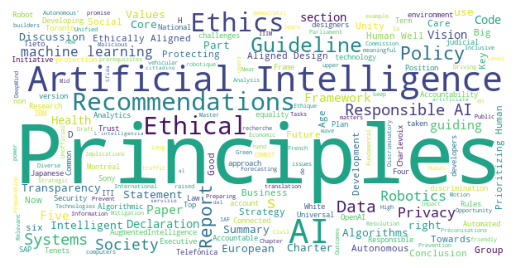

In [42]:
# gather the words from 'Name of Document/Website', 'Name of guidelines/principles'
# replace nans with empty str
# join the values together separating with new lines
words = "\n".join(df_pypdf[['Name of Document/Website', 'Name of guidelines/principles']].fillna("").values.flatten())

# initialise the WordCloud
wc = wordcloud.WordCloud(
    width=600,
    height=300,
    max_font_size=100,
    background_color="white",
    stopwords=wordcloud.STOPWORDS,
    random_state=500,
)

# generate the wordcloud
wc.generate(words)

# show the wordcloud
plt.imshow(wc)
plt.axis("off")
plt.show()

- The document was written in 2019 and collecting the value counts by year over the time leading up to the article shows the exponential rise in AI policy creation.
- The distribution of policy locations reveals that the US and EU was leading the way with policy generation. Although, there could be __bias__ in this data based upon the language of those compiling the policy lists.

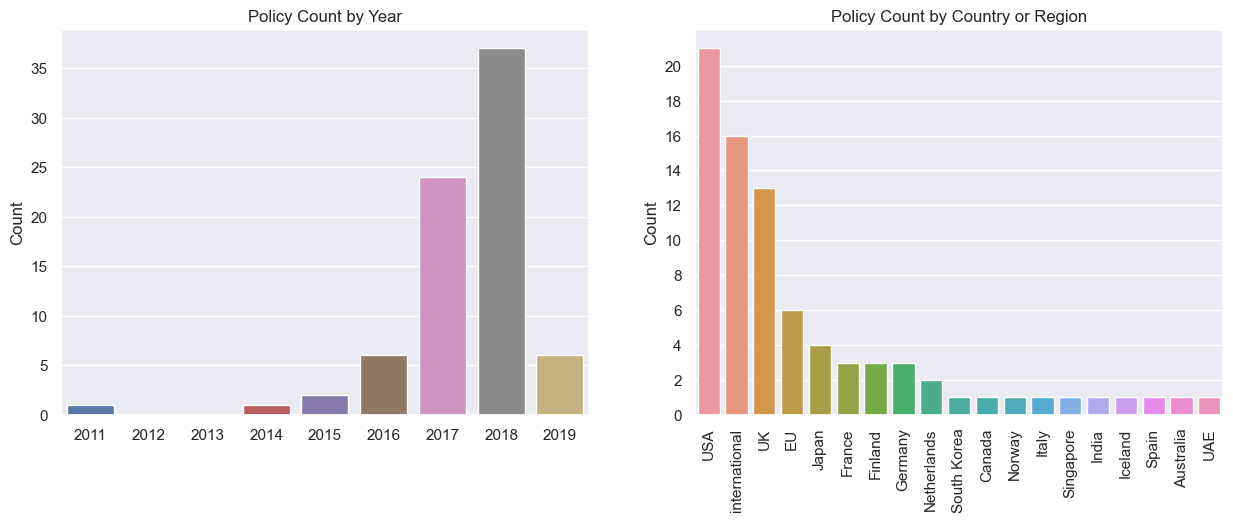

In [44]:
# draw a double figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# contruct initialise count data to zero for contiguous years between 2011, 2020
year_counts = pandas.Series({year: 0 for year in range(2011, 2020)}, name="Count")
year_counts.index.name = "Year"

# add the numbers from .value_counts()
year_counts += df_pypdf["Year"].value_counts()

# count by year
seaborn.barplot(
    year_counts.fillna(0).reset_index(),
    y="Count",
    x="Year",
    ax=ax[0],
)
ax[0].set_xlabel("")
ax[0].set_title("Policy Count by Year")


# policy count by country
seaborn.barplot(
    df_pypdf["Country of issuer"].value_counts().reset_index(),
    y="count",
    x="Country of issuer",
    ax=ax[1],
)

# formatting
[tick.set_rotation(90) for tick in ax[1].get_xticklabels()]
ax[1].set_title("Policy Count by Country or Region")
ax[1].set_yticks(range(0, 22, 2))
ax[1].set_xlabel("")
ax[1].set_ylabel("Count")

plt.show()

AI ethics has an important impact on the lives of everyone.
The target audience for these policies shows the wide-range of audiences considered in these policies.

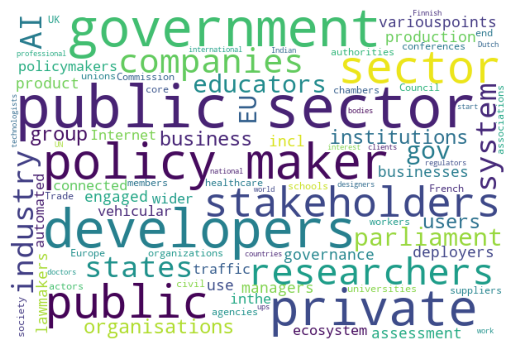

In [46]:
# initialise the WordCloud
wc = wordcloud.WordCloud(
    width=600,
    height=400,
    background_color="white",
    stopwords=wordcloud.STOPWORDS | {'multiple', 'unspecified', 'self'},
    random_state=1,
)

# generate the wordcloud
wc.generate(
    "\n".join(df_pypdf['Target audience']),
)

# show the wordcloud
plt.imshow(wc)
plt.axis("off")
plt.show()

## Conclusions

This ended up being a very deep rabbit hole!

The PDF is a versatile document that is inescapable in the modern world but the data stored within is not structured at all.
Simply asking _"How to get some tabular text from a PDF document?"_ led to a  detailed look at the PDF file format.
`pypdf` is not an ideal tool for extracting data from a PDF but does allow interaction with all the elements within the document.

I devised a strategy that resulted in complete reconstitution pf Table 2 from the supporting information of the 2019 article ["The Global Landscape of AI Ethics Guidelines"](https://doi.org/10.1038/s42256-019-0088-2):
- The rectangles on the page were located - these correspond to the table cell borders.
- The text on the page was located and decoded according to the font specifications.
- The text was collected to each rectangle by location.
- The rectangle locations were converted to table row and columns and a DataFrame was constructed. 

This produced an almost perfect reproduction of the data from the PDF.

__BUT__ There __must__ be an easier way! There is and that can be found in [__Part 2__]("Extracting_Data_from_a_PDF_Table_Part_2.ipynb")! 
There are many packages that have been created to streamline this process. 
These packages use various strategies for table extraction including: 
the same line/rectangle finding strategy as above;
to grouping text by position alone;
and AI and machine learning techniques.